In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
import mizani
import numpy as np
plt.style.use('ggplot')

In [2]:
jhu_daily_data = "../data/daily.df"
jhu = pd.read_pickle(jhu_daily_data)

jhu['Date'] = jhu['Date'].apply(lambda x: x.to_timestamp()) 
jhu['Last_Update'] = pd.to_datetime(jhu['Last_Update'])

## Preprocessing John Hopkins University Data

* Extract Data for only US
* Fix State columns (the format of data changed from January to May)
* Combine data per state (JHU data is at county level)

## set the training data set end date and test dataset start date here



In [3]:
end_date_train = '2020-05-09'
start_date_test = '2020-05-10'

In [4]:
#Selecting only US Data:
#jhu['Counrty/Region'] = jhu['Country_Region']
jhu1 = jhu.loc[jhu['Country/Region'] == 'US']
jhu2 = jhu.loc[jhu['Country_Region'] == 'US']
jhus=[jhu1,jhu2]

jhus = pd.concat(jhus)

print(jhus.shape)

#Fill NaN values in 'Province/State' column with 'Province_State' values
jhus['Province/State'].fillna(jhus['Province_State'], inplace=True)

#Discard data about Diamond Princess and Guam (b/c no safeGraph data)
jhus=jhus[~jhus['Province/State'].str.contains('Princess')]
jhus=jhus[~jhus['Province/State'].str.contains('Guam')]
print("After dropping Guam and Diamond Princess:", jhus.shape)

states_abb = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "D.C.", "DE", "FL", "GA", 
              "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
              "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
              "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
              "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "Puerto Rico"]

states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
          "Connecticut","District of Columbia","District of Columbia","Delaware",
          "Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa","Kansas",
          "Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan",
          "Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada",
          "New Hampshire","New Jersey","New Mexico","New York","North Carolina",
          "North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania","Rhode Island",
          "South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont",
          "Virginia","Washington","West Virginia","Wisconsin","Wyoming", "Puerto Rico"]

for i in range(len(states_abb)):
    idx = jhus['Province/State'].str.contains(states_abb[i])
    jhus.loc[idx,'Province_State'] = states[i]

for i in range(len(states)):
    idx = jhus['Province/State'].str.contains(states[i])
    jhus.loc[idx,('Province_State')] = states[i]    

#Find rows that do not contain valid State Names (e.g. Virgin Islands, American Samoa)
idx = ~jhus['Province_State'].isin(states)
jhus.loc[idx,('Province_State')] = np.NaN

#Drop remaining NaN Values in Province_State (this discards data from Virgin Islands)
jhus.dropna(subset=['Province_State'], inplace=True)
print("after dropping NaN:", jhus.shape)

jhus.head()

(188031, 18)
After dropping Guam and Diamond Princess: (187736, 18)
after dropping NaN: (187518, 18)


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Date,Latitude,Longitude,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key
31,Washington,US,1/22/2020 17:00,1.0,NaN,NaN,2020-01-22,NaN,NaN,NaN,NaN,Washington,NaN,NaT,NaN,NaN,NaN,NaN
31,Washington,US,1/23/20 17:00,1.0,NaN,NaN,2020-01-23,NaN,NaN,NaN,NaN,Washington,NaN,NaT,NaN,NaN,NaN,NaN
33,Washington,US,1/24/20 17:00,1.0,NaN,NaN,2020-01-24,NaN,NaN,NaN,NaN,Washington,NaN,NaT,NaN,NaN,NaN,NaN
33,Washington,US,1/25/20 17:00,1.0,NaN,NaN,2020-01-25,NaN,NaN,NaN,NaN,Washington,NaN,NaT,NaN,NaN,NaN,NaN
34,Illinois,US,1/25/20 17:00,1.0,NaN,NaN,2020-01-25,NaN,NaN,NaN,NaN,Illinois,NaN,NaT,NaN,NaN,NaN,NaN


In [5]:
print('Total number of states:', jhus['Province_State'].nunique())

Total number of states: 52


In [6]:
# Total cases in US daily:
jhu_totals = jhus.groupby('Date').sum().reset_index()

# Daily cases per State:
jhu_state = jhus.groupby(['Date','Province_State']).sum().reset_index()

# Last reported number of cases per State:
date = jhu_state.nlargest(1,'Date')
print(date['Date'])

latest = jhu_state.loc[jhu_state['Date'] == '2020-05-24'] #change according to date as new data is downloaded
latest.head()

4353   2020-05-25
Name: Date, dtype: datetime64[ns]


,Date,Province_State,Confirmed,Deaths,Recovered,Latitude,Longitude,FIPS,Lat,Long_,Active
4301,2020-05-24,Alabama,14478.0,551.0,0.0,0.0,0.0,161490.0,2203.246784,-5809.578199,13927.0
4302,2020-05-24,Alaska,407.0,10.0,0.0,0.0,0.0,122355.0,912.585588,-2195.321764,397.0
4303,2020-05-24,Arizona,16377.0,801.0,0.0,0.0,0.0,150212.0,505.138555,-1671.948482,15576.0
4304,2020-05-24,Arkansas,5922.0,116.0,0.0,0.0,0.0,465617.0,2584.835716,-6840.048626,5806.0
4305,2020-05-24,California,94020.0,3754.0,0.0,0.0,0.0,435321.0,2153.360119,-6881.533980,90266.0


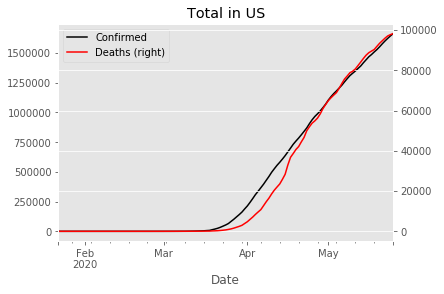

In [7]:
ax = jhu_totals.plot(x='Date',y='Confirmed',c='k',title='Total in US')
_ = jhu_totals.plot(x='Date',y='Deaths',secondary_y=True,ax=ax,c='r')

In [8]:
print(jhu_state.shape)
jhu_state.head()

#ax = jhu_state.plot(x='Date',y='Confirmed',c='k')
#_ = jhu_totals.plot(x='Date',y='Deaths',secondary_y=True,ax=ax,c='r')

(4405, 11)


,Date,Province_State,Confirmed,Deaths,Recovered,Latitude,Longitude,FIPS,Lat,Long_,Active
0,2020-01-22,Washington,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,Washington,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,Washington,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,Illinois,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-25,Washington,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
jhu_state.tail()

,Date,Province_State,Confirmed,Deaths,Recovered,Latitude,Longitude,FIPS,Lat,Long_,Active
4400,2020-05-25,Virginia,37727.0,1208.0,0.0,0.0,0.0,6908162.0,4996.297993,-10442.323661,36519.0
4401,2020-05-25,Washington,20065.0,1070.0,0.0,0.0,0.0,2158574.0,1842.117670,-4708.049596,18995.0
4402,2020-05-25,West Virginia,1774.0,72.0,0.0,0.0,0.0,2954961.0,2057.019673,-4272.833081,1702.0
4403,2020-05-25,Wisconsin,15584.0,514.0,0.0,0.0,0.0,4055174.0,3196.450332,-6465.454559,15070.0
4404,2020-05-25,Wyoming,843.0,12.0,0.0,0.0,0.0,1322540.0,947.158755,-2359.957083,831.0


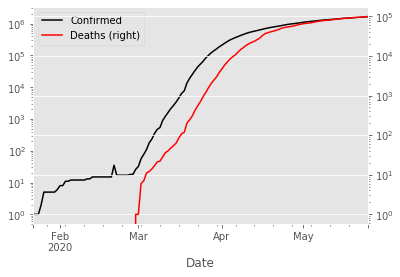

In [10]:
ax = jhu_totals.plot(x='Date',y='Confirmed',c='k',logy=True)
_ = jhu_totals.plot(x='Date',y='Deaths',secondary_y=True,ax=ax,c='r',logy=True)

In [11]:
# 10 States with largest number of Confirmed cases today:
jhu_largest_state = latest.nlargest(10,'Confirmed')
print('Top 10 States with highest confirmed Cases')
jhu_largest_state

Top 10 States with highest confirmed Cases


,Date,Province_State,Confirmed,Deaths,Recovered,Latitude,Longitude,FIPS,Lat,Long_,Active
4333,2020-05-24,New York,361515.0,29141.0,0.0,0.0,0.0,2181662.0,2474.952404,-4383.622249,332374.0
4331,2020-05-24,New Jersey,154154.0,11138.0,0.0,0.0,0.0,804475.0,846.015259,-1567.071444,143016.0
4314,2020-05-24,Illinois,110304.0,4856.0,0.0,0.0,0.0,1897267.0,4024.406089,-9005.711523,105448.0
4305,2020-05-24,California,94020.0,3754.0,0.0,0.0,0.0,435321.0,2153.360119,-6881.533980,90266.0
4322,2020-05-24,Massachusetts,92675.0,6372.0,0.0,0.0,0.0,390195.0,548.293200,-930.501649,86303.0
4339,2020-05-24,Pennsylvania,71563.0,5136.0,0.0,0.0,0.0,2908531.0,2734.811250,-5200.226295,66427.0
4345,2020-05-24,Texas,55861.0,1528.0,0.0,0.0,0.0,11042659.0,7197.086324,-22330.550323,54333.0
4323,2020-05-24,Michigan,54679.0,5228.0,0.0,0.0,0.0,2256784.0,3515.365820,-6806.532423,49451.0
4310,2020-05-24,Florida,50867.0,2237.0,0.0,0.0,0.0,898562.0,1939.030577,-5540.949842,48630.0
4321,2020-05-24,Maryland,46313.0,2277.0,0.0,0.0,0.0,667103.0,936.358097,-1840.211223,44036.0


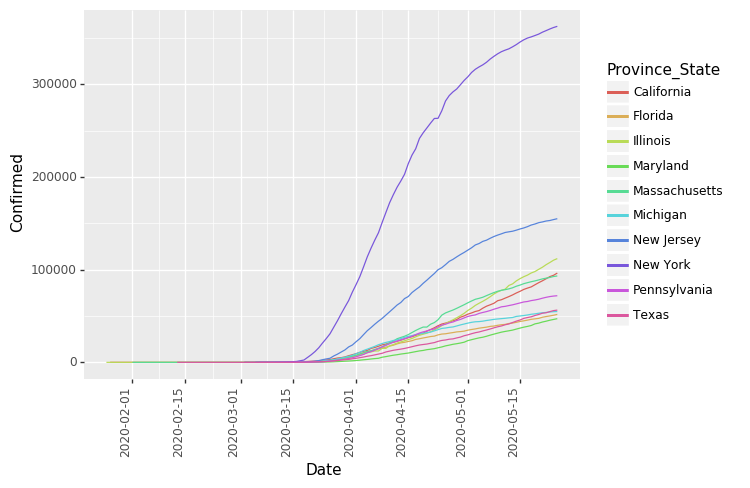

<ggplot: (-9223371913058456292)>

In [12]:
(p9.ggplot(data=jhu_state[jhu_state['Province_State'].isin(jhu_largest_state['Province_State'])],
           mapping=p9.aes(x='Date',
                          y='Confirmed',
                          color='Province_State'))
    + p9.geom_line()
    + p9.theme(axis_text_x = p9.element_text(angle = 90, hjust = 1))
)

## Adding Population Data Per State to Calculate Incident Rate

* Looking at Confirmed cases is not the best feature because population introduces bias
* We will calculate Incident Rate (number of cases per 100'000 people)

In [13]:
## Load 2019 population data from census

population = pd.read_csv('../data/population.csv')
#population.tail()

In [14]:
population.loc[~(population['NAME'].where(population['NAME'].str.contains('Puerto'))).isnull(),'NAME']='Puerto Rico'

In [15]:
population.tail()

,SUMLEV,REGION,DIVISION,STATE,NAME,POPESTIMATE2019,POPEST18PLUS2019,PCNT_POPEST18PLUS
48,40,4,9,53,Washington,7614893,5951832,78.2
49,40,3,5,54,West Virginia,1792147,1432580,79.9
50,40,2,3,55,Wisconsin,5822434,4555837,78.2
51,40,4,8,56,Wyoming,578759,445025,76.9
52,40,X,X,72,Puerto Rico,3193694,2620963,82.1


In [16]:
jhu_state['Population'] = np.zeros(len(jhu_state['Province_State']))
## Add population column per State
for j in range(len(population['NAME'])):
    for i in range(len(jhu_state['Province_State'])):
        if jhu_state.loc[i,'Province_State'] == population.loc[j,'NAME']:
            jhu_state.loc[i,'Population'] = population.loc[j,'POPESTIMATE2019']

In [17]:
jhu_state.tail()

,Date,Province_State,Confirmed,Deaths,Recovered,Latitude,Longitude,FIPS,Lat,Long_,Active,Population
4400,2020-05-25,Virginia,37727.0,1208.0,0.0,0.0,0.0,6908162.0,4996.297993,-10442.323661,36519.0,8535519.0
4401,2020-05-25,Washington,20065.0,1070.0,0.0,0.0,0.0,2158574.0,1842.117670,-4708.049596,18995.0,7614893.0
4402,2020-05-25,West Virginia,1774.0,72.0,0.0,0.0,0.0,2954961.0,2057.019673,-4272.833081,1702.0,1792147.0
4403,2020-05-25,Wisconsin,15584.0,514.0,0.0,0.0,0.0,4055174.0,3196.450332,-6465.454559,15070.0,5822434.0
4404,2020-05-25,Wyoming,843.0,12.0,0.0,0.0,0.0,1322540.0,947.158755,-2359.957083,831.0,578759.0


In [18]:
## Calculate confirmed cases per 100,000 people

jhu_state['Incident_Rate'] = jhu_state['Confirmed']/jhu_state['Population']*100000

In [19]:
jhu_state.tail()

,Date,Province_State,Confirmed,Deaths,Recovered,Latitude,Longitude,FIPS,Lat,Long_,Active,Population,Incident_Rate
4400,2020-05-25,Virginia,37727.0,1208.0,0.0,0.0,0.0,6908162.0,4996.297993,-10442.323661,36519.0,8535519.0,442.000071
4401,2020-05-25,Washington,20065.0,1070.0,0.0,0.0,0.0,2158574.0,1842.117670,-4708.049596,18995.0,7614893.0,263.496808
4402,2020-05-25,West Virginia,1774.0,72.0,0.0,0.0,0.0,2954961.0,2057.019673,-4272.833081,1702.0,1792147.0,98.987416
4403,2020-05-25,Wisconsin,15584.0,514.0,0.0,0.0,0.0,4055174.0,3196.450332,-6465.454559,15070.0,5822434.0,267.654386
4404,2020-05-25,Wyoming,843.0,12.0,0.0,0.0,0.0,1322540.0,947.158755,-2359.957083,831.0,578759.0,145.656482


In [20]:
## Delete unnecessary columns
jhu_state = jhu_state.drop(['FIPS','Lat','Long_','Latitude','Longitude'],axis=1)

In [21]:
latest = jhu_state.loc[jhu_state['Date'] == '2020-05-24'] #change according to date as new data is downloaded
latest.head()

,Date,Province_State,Confirmed,Deaths,Recovered,Active,Population,Incident_Rate
4301,2020-05-24,Alabama,14478.0,551.0,0.0,13927.0,4903185.0,295.277457
4302,2020-05-24,Alaska,407.0,10.0,0.0,397.0,731545.0,55.635675
4303,2020-05-24,Arizona,16377.0,801.0,0.0,15576.0,7278717.0,224.998444
4304,2020-05-24,Arkansas,5922.0,116.0,0.0,5806.0,3017804.0,196.235408
4305,2020-05-24,California,94020.0,3754.0,0.0,90266.0,39512223.0,237.951684


In [22]:
# 10 States with highest incident rate (confirmed cases per 100,000 people):
jhu_high_incident_state = latest.nlargest(10,'Incident_Rate')

In [23]:
jhu_high_incident_state

,Date,Province_State,Confirmed,Deaths,Recovered,Active,Population,Incident_Rate
4333,2020-05-24,New York,361515.0,29141.0,0.0,332374.0,19453561.0,1858.348711
4331,2020-05-24,New Jersey,154154.0,11138.0,0.0,143016.0,8882190.0,1735.540447
4322,2020-05-24,Massachusetts,92675.0,6372.0,0.0,86303.0,6892503.0,1344.576854
4341,2020-05-24,Rhode Island,14065.0,608.0,0.0,13457.0,1059361.0,1327.687162
4309,2020-05-24,District of Columbia,8110.0,432.0,0.0,7678.0,705749.0,1149.133757
4307,2020-05-24,Connecticut,40468.0,3693.0,0.0,36775.0,3565287.0,1135.055888
4308,2020-05-24,Delaware,8809.0,326.0,0.0,8483.0,973764.0,904.633977
4314,2020-05-24,Illinois,110304.0,4856.0,0.0,105448.0,12671821.0,870.466841
4319,2020-05-24,Louisiana,37169.0,2691.0,0.0,34478.0,4648794.0,799.540698
4321,2020-05-24,Maryland,46313.0,2277.0,0.0,44036.0,6045680.0,766.051131


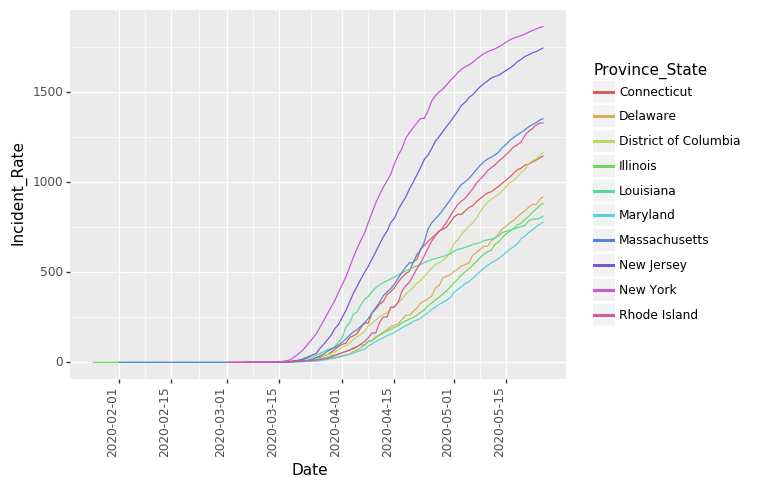

<ggplot: (-9223371913058344080)>

In [24]:
(p9.ggplot(data=jhu_state[jhu_state['Province_State'].isin(jhu_high_incident_state['Province_State'])],
           mapping=p9.aes(x='Date',
                          y='Incident_Rate',
                          color='Province_State'))
    + p9.geom_line()
    + p9.theme(axis_text_x = p9.element_text(angle = 90, hjust = 1))
)

## Calculate Number of days elapsed since Incident Rate exceeded 0.5 per State

* We will use this as a feature in our dataset, since date is an important metric in predicting the incidence rate

In [25]:
## Compute number of days elapsed since incident rate crossed threshold of 0.5

threshold = 0.5
new_data = pd.DataFrame()
States = np.unique(jhu_state['Province_State'])

for state in States:
    state_data = jhu_state.groupby(['Province_State']).get_group(state)
    cond = (state_data['Incident_Rate'] > threshold) & (state_data['Incident_Rate'].shift(1) <= threshold)
    d = state_data.loc[cond]
    thresh = d['Date'].nsmallest(1,keep='first')
    basedate = thresh
    if d.empty:
        state_data['Elapsed_Days'] = 0
    else:
        state_data['Elapsed_Days'] = np.hstack([(date - basedate).dt.days for date in state_data['Date']])
    new_data = new_data.append(state_data)
    #cross_row_inds = d[(d['Date'] >= START_TIME) & (d['Date'] <= END_TIME)].index

In [26]:
jhu_state = new_data.sort_index(0)
neg_idx = jhu_state.index[jhu_state['Elapsed_Days'] < 0]
jhu_state.loc[neg_idx,'Elapsed_Days'] = 0

In [27]:
jhu_state

,Date,Province_State,Confirmed,Deaths,Recovered,Active,Population,Incident_Rate,Elapsed_Days
0,2020-01-22,Washington,1.0,0.0,0.0,0.0,7614893.0,0.013132,0
1,2020-01-23,Washington,1.0,0.0,0.0,0.0,7614893.0,0.013132,0
2,2020-01-24,Washington,1.0,0.0,0.0,0.0,7614893.0,0.013132,0
3,2020-01-25,Illinois,1.0,0.0,0.0,0.0,12671821.0,0.007892,0
4,2020-01-25,Washington,1.0,0.0,0.0,0.0,7614893.0,0.013132,0
...,...,...,...,...,...,...,...,...,...
4400,2020-05-25,Virginia,37727.0,1208.0,0.0,36519.0,8535519.0,442.000071,71
4401,2020-05-25,Washington,20065.0,1070.0,0.0,18995.0,7614893.0,263.496808,82
4402,2020-05-25,West Virginia,1774.0,72.0,0.0,1702.0,1792147.0,98.987416,64
4403,2020-05-25,Wisconsin,15584.0,514.0,0.0,15070.0,5822434.0,267.654386,71


## Add Shelter-in-Place Index from Safegraph

* We will use percentage of people staying home as a feature in our dataset to predict the incident rate
* The percentage staying home dataset is downloaded from Rill Data who computed the percentages from Safegraph data. This way we avoided downloading 60GB of data from Safegraph

In [28]:
## Add percentage staying home feature from Safegraph

percentage_home = pd.read_csv('../data/safegraph.csv')
date = percentage_home['__timestamp'].str.split(" ", n = 1, expand = True) 
percentage_home['Date'] = pd.to_datetime(date[0]) 
percentage_home = percentage_home.drop(columns=['__timestamp'])
percentage_home = percentage_home.rename(columns={percentage_home.columns[1]:'percentage_home'})
percentage_home

,state,percentage_home,Date
0,Puerto Rico,69.594465,2020-04-05
1,Puerto Rico,67.106363,2020-04-10
2,Puerto Rico,66.412555,2020-04-11
3,Puerto Rico,66.190164,2020-04-12
4,Puerto Rico,65.091807,2020-04-19
...,...,...,...
7535,Mississippi,15.938000,2020-01-31
7536,Mississippi,15.869747,2020-02-28
7537,Alabama,15.754319,2020-01-31
7538,Alabama,15.504751,2020-01-17


In [29]:
jhu_state['Percentage_Home'] = np.zeros(len(jhu_state))
for j in range(len(jhu_state['Province_State'])):
    cond = (jhu_state.loc[j,'Province_State'] == percentage_home['state']) & (jhu_state.loc[j,'Date'] == percentage_home['Date'])
    idx, = np.where(cond)
    if idx.shape[0] == 0: 
        jhu_state.loc[j,'Percentage_Home'] = np.nan ##Safegraph missing data for some states after 2020-05-09
    else:
        jhu_state.loc[j,'Percentage_Home'] = percentage_home.loc[idx[0],'percentage_home']

In [30]:
jhu_state.tail()

,Date,Province_State,Confirmed,Deaths,Recovered,Active,Population,Incident_Rate,Elapsed_Days,Percentage_Home
4400,2020-05-25,Virginia,37727.0,1208.0,0.0,36519.0,8535519.0,442.000071,71,NaN
4401,2020-05-25,Washington,20065.0,1070.0,0.0,18995.0,7614893.0,263.496808,82,NaN
4402,2020-05-25,West Virginia,1774.0,72.0,0.0,1702.0,1792147.0,98.987416,64,NaN
4403,2020-05-25,Wisconsin,15584.0,514.0,0.0,15070.0,5822434.0,267.654386,71,NaN
4404,2020-05-25,Wyoming,843.0,12.0,0.0,831.0,578759.0,145.656482,71,NaN


In [31]:
print(jhu_state.shape)

(4405, 10)


In [32]:
latest_safegraph = jhu_state.loc[jhu_state['Date'] == '2020-05-24'] #change according to date as new data is downloaded

# 10 States with highest shelter-in-place index (% staying home) on last updated date:
safegraph_highest_state = latest_safegraph.nlargest(10,'Percentage_Home')
safegraph_highest_state

,Date,Province_State,Confirmed,Deaths,Recovered,Active,Population,Incident_Rate,Elapsed_Days,Percentage_Home
4340,2020-05-24,Puerto Rico,3189.0,127.0,0.0,3062.0,3193694.0,99.853023,64,57.234472
4309,2020-05-24,District of Columbia,8110.0,432.0,0.0,7678.0,705749.0,1149.133757,0,43.338653
4321,2020-05-24,Maryland,46313.0,2277.0,0.0,44036.0,6045680.0,766.051131,70,40.613616
4333,2020-05-24,New York,361515.0,29141.0,0.0,332374.0,19453561.0,1858.348711,77,40.308705
4349,2020-05-24,Washington,19828.0,1061.0,0.0,18767.0,7614893.0,260.384486,81,39.301188
4331,2020-05-24,New Jersey,154154.0,11138.0,0.0,143016.0,8882190.0,1735.540447,71,39.198605
4305,2020-05-24,California,94020.0,3754.0,0.0,90266.0,39512223.0,237.951684,73,38.894683
4306,2020-05-24,Colorado,24174.0,1332.0,0.0,22842.0,5758736.0,419.779618,74,38.506040
4322,2020-05-24,Massachusetts,92675.0,6372.0,0.0,86303.0,6892503.0,1344.576854,75,38.244637
4329,2020-05-24,Nevada,7881.0,380.0,0.0,7501.0,3080156.0,255.863664,72,37.575517


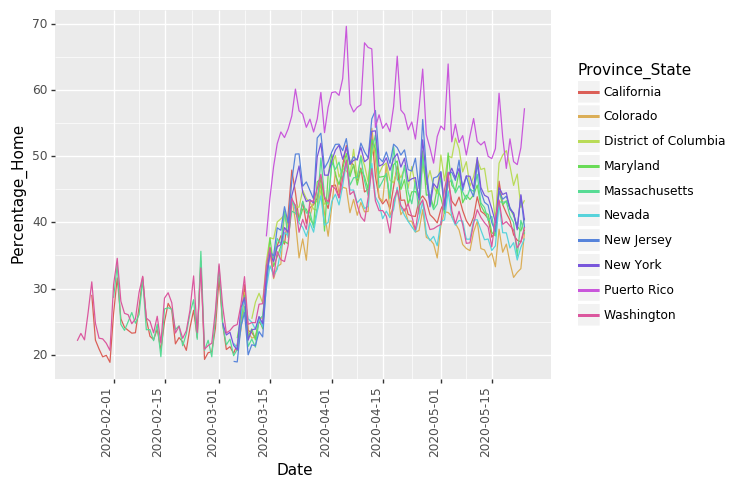

<ggplot: (-9223371913057198264)>

In [33]:
(p9.ggplot(data=jhu_state[jhu_state['Province_State'].isin(safegraph_highest_state['Province_State'])],
           mapping=p9.aes(x='Date',
                          y='Percentage_Home',
                          color='Province_State'))
    + p9.geom_line()
    + p9.theme(axis_text_x = p9.element_text(angle = 90, hjust = 1))
)

## Create Training and Test Dataset

We will be using dataset from January 22 to May 9 as our training set, and data from May 10 to May 24 as our test dataset and we will try to predict top 5 States who will see the most increase in the incident rate

In [34]:
# the end_date_train and start_date_test values are set at first
# end_date_train = '2020-05-09'
# start_date_test = '2020-05-10'

mask_train = (jhu_state['Date'] <= end_date_train)
mask_test = (jhu_state['Date'] >= start_date_test)

train = jhu_state.loc[mask_train]
test = jhu_state.loc[mask_test]

## Training Data
X_tr = train.loc[:,['Date','Province_State','Population','Elapsed_Days','Percentage_Home']]
y_tr = train.loc[:,['Date','Incident_Rate']]
                     
## Test Data 
X_te = test.loc[:,['Date','Province_State','Population','Elapsed_Days','Percentage_Home']]
y_te = test.loc[:,['Date','Incident_Rate']]

In [35]:
print(X_tr.shape)
print(y_tr.shape)
print(X_te.shape)
print(y_te.shape)

(3573, 5)
(3573, 2)
(832, 5)
(832, 2)


In [36]:
X_tr.head()

,Date,Province_State,Population,Elapsed_Days,Percentage_Home
0,2020-01-22,Washington,7614893.0,0,22.113481
1,2020-01-23,Washington,7614893.0,0,23.233285
2,2020-01-24,Washington,7614893.0,0,22.260950
3,2020-01-25,Illinois,12671821.0,0,25.471592
4,2020-01-25,Washington,7614893.0,0,26.418402


In [37]:
X_te.head()

,Date,Province_State,Population,Elapsed_Days,Percentage_Home
3573,2020-05-10,Alabama,4903185.0,55,26.622293
3574,2020-05-10,Alaska,731545.0,53,33.555901
3575,2020-05-10,Arizona,7278717.0,52,38.224841
3576,2020-05-10,Arkansas,3017804.0,56,26.700268
3577,2020-05-10,California,39512223.0,59,40.783996


In [38]:
X_tr.to_csv('../data/X_tr.csv', index=False)   
y_tr.to_csv('../data/y_tr.csv', index=False)  
X_te.to_csv('../data/X_te.csv', index=False)   
y_te.to_csv('../data/y_te.csv', index=False)  